## Step1: Put all libraries and packages at top

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [5]:
random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu

## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [7]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180), # allow any rotation
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to augment or not

In [33]:
# Method 2: Save images to folder and create a custom dataloader that loads them from their path. More involved than method 1 but allows for greater flexibility
# Requires 3 functions: __init__ to initialize the object, and __len__ and __get__item for pytorch purposes. More functions can be added as needed, but those 3 are necessary for it to function with pytorch
class myDataSet(object):

    def __init__(self, ids, path_images, path_masks, transforms):
        "Initialization"
        self.ids = ids
        self.path_images = path_images
        self.path_masks = path_masks
        self.transforms = transforms

    def __len__(self):
        "Returns length of dataset"
        return len(self.ids)  

    def __getitem__(self, index):
        "Return next item of dataset"
        # Define path to current image and corresponding mask
        path_img = os.path.join(self.path_images, self.ids[index])
        path_mask = os.path.join(self.path_masks, self.ids[index])

        # Load image and mask:
        #     .jpeg has 3 channels, channels recorded last
        #     .jpeg records values as intensities from 0 to 255
        #     masks for some reason have values different to 0 or 255: 0, 1, 2, 3, 4, 5, 6, 7, 248, 249, 250, 251, 252, 253, 254, 255
        img = imageio.imread(path_img) / 255
        mask = imageio.imread(path_mask)[:, :, 0] / 255
        mask = mask.round() # binarize to 0 or 1 
        
        # for debugging
        #
        # print(path_img)
        # print(img.shape, mask.shape)
        # print(np.unique(mask))
        # print(type(img), type(mask))
        # assert img.shape[0, 1] == mask.shape[0, 1]

        # transformations applied to the image/mask
        #
        # resize both
        # img = cv2.resize(img, (256, 256))
        # mask = cv2.resize(mask, (256, 256))
        
        # convert to Tensors and fix the dimentions
        img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])) # Pytorch uses the channels in the first dimension
        mask = torch.FloatTensor(mask).unsqueeze(0) # Adding channel dimension to label
        
        # apply transforms/augmentation to both image and mask together
        sample = torch.cat((img, mask), 0) # insures that the same transform is applied
        sample = self.transforms(sample)
        img = sample[:img.shape[0], ...]
        mask = sample[img.shape[0]:, ...]

        return img, mask

path_images = "../datasets/train-val/images"
path_masks = "../datasets/train-val/masks"


# pre-defined split
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=test_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [34]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

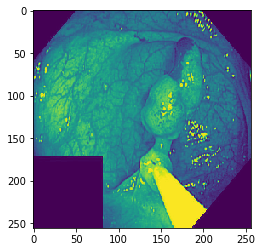

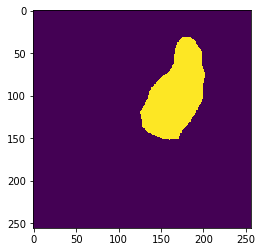

In [35]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [36]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [37]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Losses

Credit to: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

In [38]:
def iou_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

In [39]:
def iou_pytorch_test(outputs: torch.Tensor, labels: torch.Tensor):
    
    # BATCH x H x W
    assert len(outputs.shape) == 3
    assert len(labels.shape) == 3

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5
    labels = labels > 0.5

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    return iou.mean()

In [40]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return -IoU

#PyTorch
class IoUBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = - (intersection + smooth)/(union + smooth)
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        IoU_BCE = BCE + IoU
                
        return IoU_BCE

# Model Architecture

In [41]:
def compute_attention_mask(dec):
    original_dtype = dec.dtype
    
    dec = torch.sigmoid(dec)             # squash into [0, 1]
    dec = (dec > 0.5).to(original_dtype) # binarize and return to original type
    
    return dec

In [42]:
# initialize BATCH * Channel * H * W
enc2 = torch.FloatTensor(1, 1, 3, 6).uniform_(-10, 10)
print(enc2)
dec0 = torch.FloatTensor(1, 1, 2, 5).uniform_(-10, 10)
print(dec0)

print(dec0.dtype)

# compute padding margins
diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]

# # squash into [0, 1]
# dec0 = torch.sigmoid(dec0)
# # binarize
# dec0 = (dec0 > 0.5).to(torch.float)
# # pad with zeros
dec0 = compute_attention_mask(dec0)

dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
print(dec0)

# attention on high-res features
print(enc2*dec0)

# what goes as input further
torch.cat((enc2, enc2*dec0), dim=1)

tensor([[[[ 2.4547, -1.8249,  8.3004, -5.9918,  9.9971, -6.0006],
          [-3.1031,  4.1674,  8.9959,  8.0892,  7.6468,  5.5382],
          [ 6.6057, -6.8533,  9.7520,  6.3084, -4.0613,  8.5114]]]])
tensor([[[[ 0.4250, -9.2302,  7.6715,  3.1206, -6.5082],
          [-3.4422,  5.1686,  7.9445, -2.9906,  4.3727]]]])
torch.float32
tensor([[[[1., 0., 1., 1., 0., 0.],
          [0., 1., 1., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0.]]]])
tensor([[[[ 2.4547, -0.0000,  8.3004, -5.9918,  0.0000, -0.0000],
          [-0.0000,  4.1674,  8.9959,  0.0000,  7.6468,  0.0000],
          [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000]]]])


tensor([[[[ 2.4547, -1.8249,  8.3004, -5.9918,  9.9971, -6.0006],
          [-3.1031,  4.1674,  8.9959,  8.0892,  7.6468,  5.5382],
          [ 6.6057, -6.8533,  9.7520,  6.3084, -4.0613,  8.5114]],

         [[ 2.4547, -0.0000,  8.3004, -5.9918,  0.0000, -0.0000],
          [-0.0000,  4.1674,  8.9959,  0.0000,  7.6468,  0.0000],
          [ 0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000]]]])

In [43]:
# Define your model. In this case we're using a basic UNet architecture. The output channel for segmentation should be equal to number of classes we want to segment the image into. For a binary segmentation, this is a value of 1.
class UNet(torch.nn.Module):

    def conv_block(self, channel_in, channel_out):
        return torch.nn.Sequential(
            torch.nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(channel_out, channel_out, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(channel_out),
            torch.nn.ReLU(inplace=True)
        )


    def __init__(self, channel_in, channel_out, bilinear=None):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        
        # initial convolutional block
        self.initial = self.conv_block(channel_in, 64)
        
        # encoder layers
        self.down0 = self.conv_block(64, 128)
        self.down1 = self.conv_block(128, 256)
        self.down2 = self.conv_block(256, 512)
        self.down3 = self.conv_block(512, 1024)
        
        # decoder layers
        self.up0_0 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up0_1 = self.conv_block(1024, 512)
        self.up1_0 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1_1 = self.conv_block(512, 256)
        self.up2_0 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2_1 = self.conv_block(256, 128)
        self.up3_0 = torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3_1 = self.conv_block(128, 64)
        
        # final layer before output
        self.final = torch.nn.Conv2d(64, channel_out, kernel_size=1)

    def forward(self,x):
        "Forward pass"
        x_in= self.initial(x)
        enc0 = self.down0(torch.nn.MaxPool2d(2)(x_in))
        enc1 = self.down1(torch.nn.MaxPool2d(2)(enc0))
        enc2 = self.down2(torch.nn.MaxPool2d(2)(enc1))
        enc3 = self.down3(torch.nn.MaxPool2d(2)(enc2))
        
        dec0 = self.up0_0(enc3)
        dec0 = compute_attention_mask(dec0)
        diff0 = torch.FloatTensor(list(enc2.size())[2:]) - torch.FloatTensor(list(dec0.shape))[2:]
        dec0 = torch.nn.functional.pad(dec0, (int((diff0/2).floor()[0]), int((diff0/2).ceil()[0]), int((diff0/2).floor()[1]), int((diff0/2).ceil()[1])))
        dec0 = self.up0_1(torch.cat((enc2, enc2*dec0), dim=1))

        dec1 = self.up1_0(dec0)
        dec1 = compute_attention_mask(dec1)
        diff1 = torch.FloatTensor(list(enc1.size())[2:]) - torch.FloatTensor(list(dec1.shape))[2:]
        dec1 = torch.nn.functional.pad(dec1, (int((diff1/2).floor()[0]), int((diff1/2).ceil()[0]), int((diff1/2).floor()[1]), int((diff1/2).ceil()[1])))
        dec1 = self.up1_1(torch.cat((enc1, enc1*dec1), dim=1))

        dec2 = self.up2_0(dec1)
        dec2 = compute_attention_mask(dec2)
        diff2 = torch.FloatTensor(list(enc0.size())[2:]) - torch.FloatTensor(list(dec2.shape))[2:]
        dec2 = torch.nn.functional.pad(dec2, (int((diff2/2).floor()[0]), int((diff2/2).ceil()[0]), int((diff2/2).floor()[1]), int((diff2/2).ceil()[1])))
        dec2 = self.up2_1(torch.cat((enc0, enc0*dec2), dim=1))

        dec3 = self.up3_0(dec2)
        dec3 = compute_attention_mask(dec3)
        diff3 = torch.FloatTensor(list(x.size())[2:]) - torch.FloatTensor(list(dec3.shape))[2:]
        dec3 = torch.nn.functional.pad(dec3, (int((diff3/2).floor()[0]), int((diff3/2).ceil()[0]), int((diff3/2).floor()[1]), int((diff3/2).ceil()[1])))
        dec3 = self.up3_1(torch.cat((x_in, x_in*dec3), dim=1))
        
        x_out = self.final(dec3) # no activation here
        return x_out

model = UNet(channel_in=3, channel_out=1)
torchsummary.summary(model, (3, 256, 256), device='cpu') # Runs a basic test of the network. Very useful and clear!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

## Pipeline

In [44]:
def train(model, optim, criterion, dataloader, epoch, device):
    pass

In [45]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    pass

# Training hyperparameters

In [46]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [47]:
# Define variables for the training
epochs = 50

In [48]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_attention'

criterion = IoULoss()
model_name = 'UNet_IoULoss_attention'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_attention'


# Training

 Epoch: 0 of 50, Iter.: 44 of 44, Loss: -0.211378, Val. Loss: -0.207534
 Epoch: 0 of 50, Iter.: 44 of 44, IoU: 0.264578, Val. IoU: 0.239063


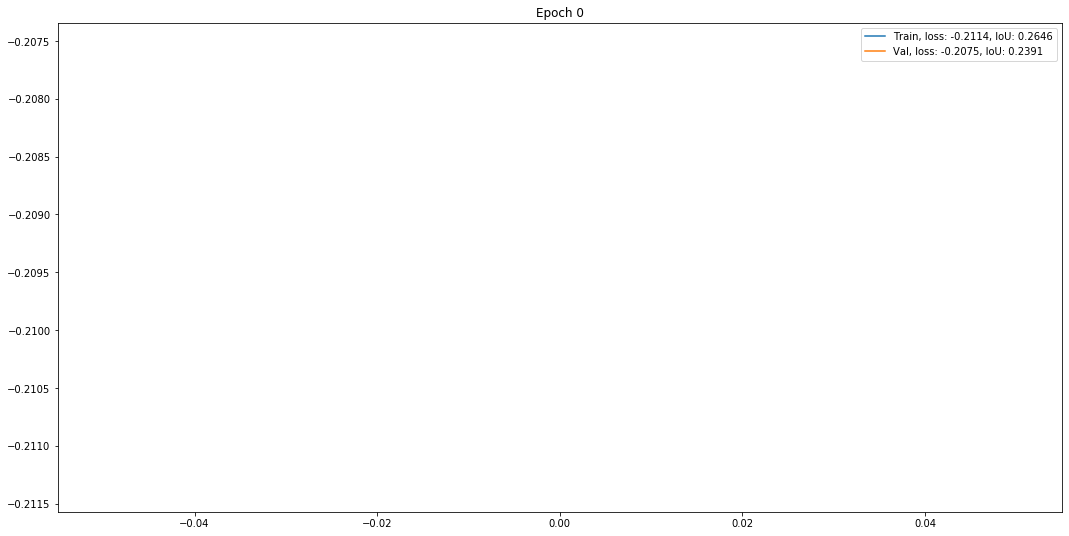

 Epoch: 1 of 50, Iter.: 44 of 44, Loss: -0.234719, Val. Loss: -0.219283
 Epoch: 1 of 50, Iter.: 44 of 44, IoU: 0.283288, Val. IoU: 0.246809


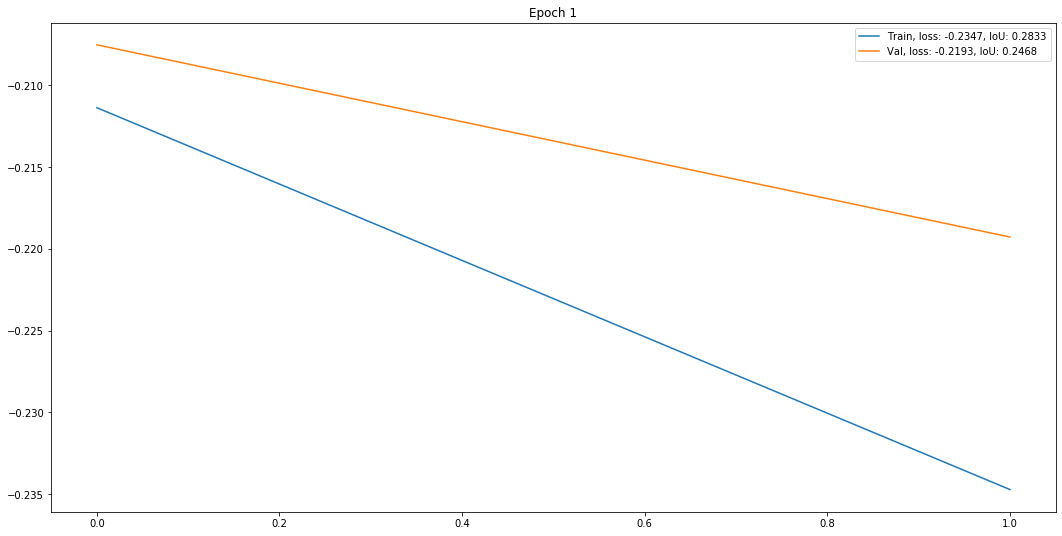

 Epoch: 2 of 50, Iter.: 44 of 44, Loss: -0.241735, Val. Loss: -0.223154
 Epoch: 2 of 50, Iter.: 44 of 44, IoU: 0.287688, Val. IoU: 0.251270


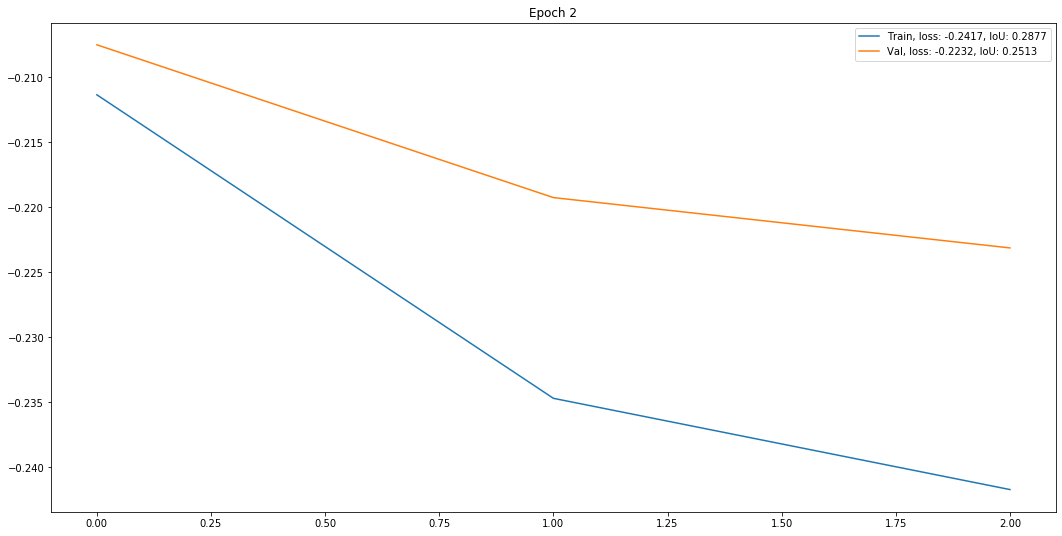

 Epoch: 3 of 50, Iter.: 44 of 44, Loss: -0.247949, Val. Loss: -0.224808
 Epoch: 3 of 50, Iter.: 44 of 44, IoU: 0.291230, Val. IoU: 0.256340


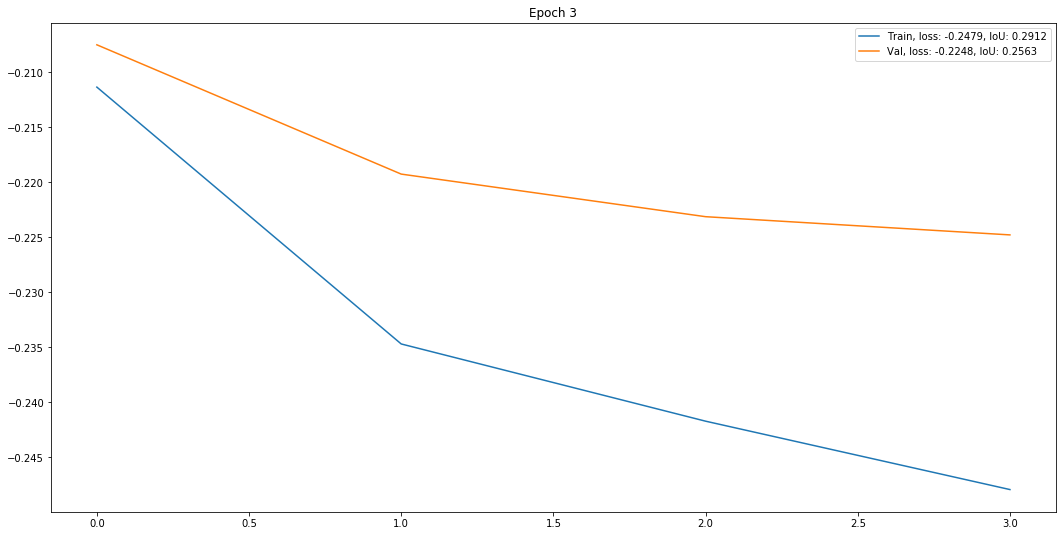

 Epoch: 4 of 50, Iter.: 44 of 44, Loss: -0.253308, Val. Loss: -0.225757
 Epoch: 4 of 50, Iter.: 44 of 44, IoU: 0.294283, Val. IoU: 0.259444


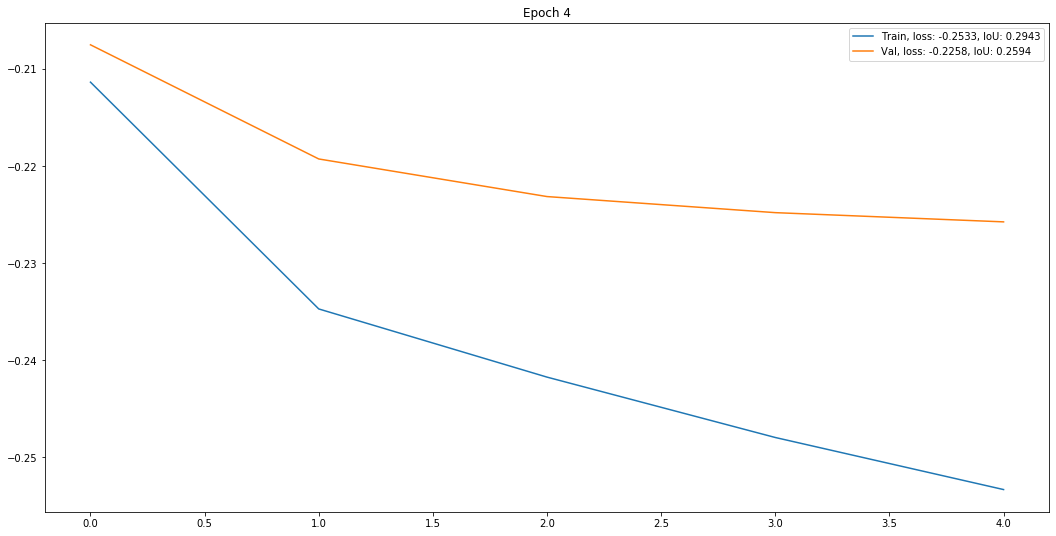

 Epoch: 5 of 50, Iter.: 44 of 44, Loss: -0.257823, Val. Loss: -0.228854
 Epoch: 5 of 50, Iter.: 44 of 44, IoU: 0.297080, Val. IoU: 0.258842


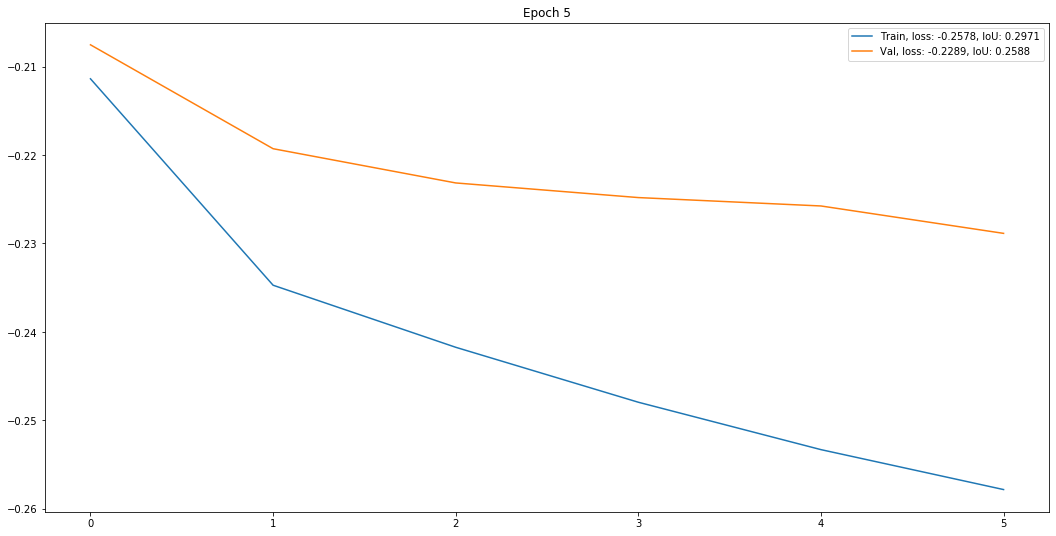

 Epoch: 6 of 50, Iter.: 44 of 44, Loss: -0.262058, Val. Loss: -0.231037
 Epoch: 6 of 50, Iter.: 44 of 44, IoU: 0.299454, Val. IoU: 0.258029


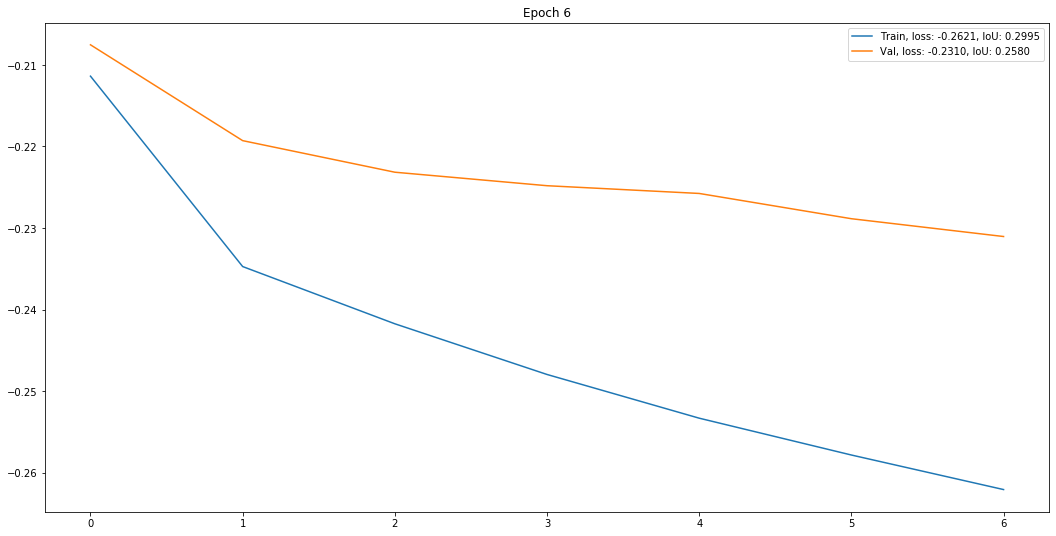

 Epoch: 7 of 50, Iter.: 44 of 44, Loss: -0.265736, Val. Loss: -0.234086
 Epoch: 7 of 50, Iter.: 44 of 44, IoU: 0.301186, Val. IoU: 0.258362


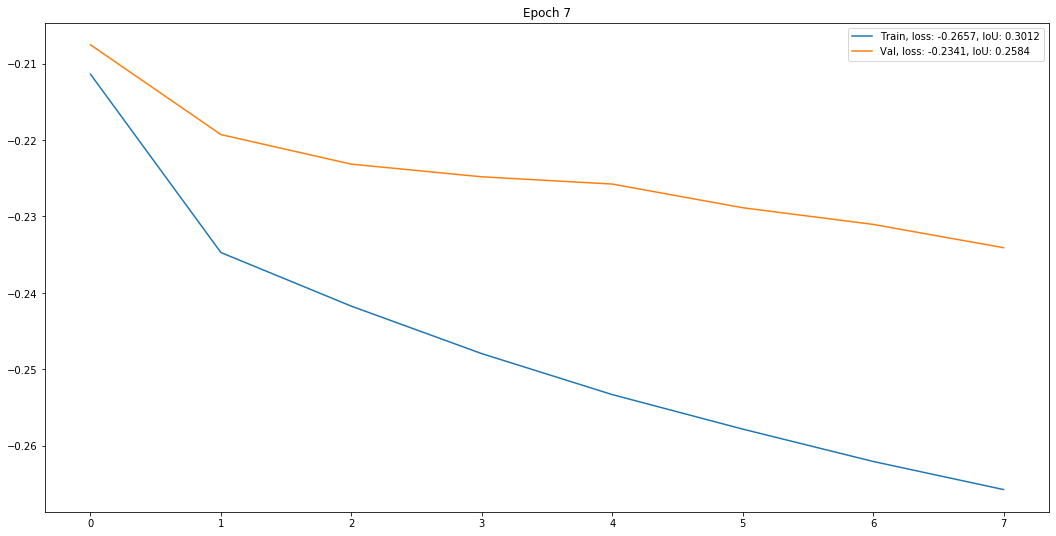

 Epoch: 8 of 50, Iter.: 44 of 44, Loss: -0.269259, Val. Loss: -0.236776
 Epoch: 8 of 50, Iter.: 44 of 44, IoU: 0.303022, Val. IoU: 0.257951


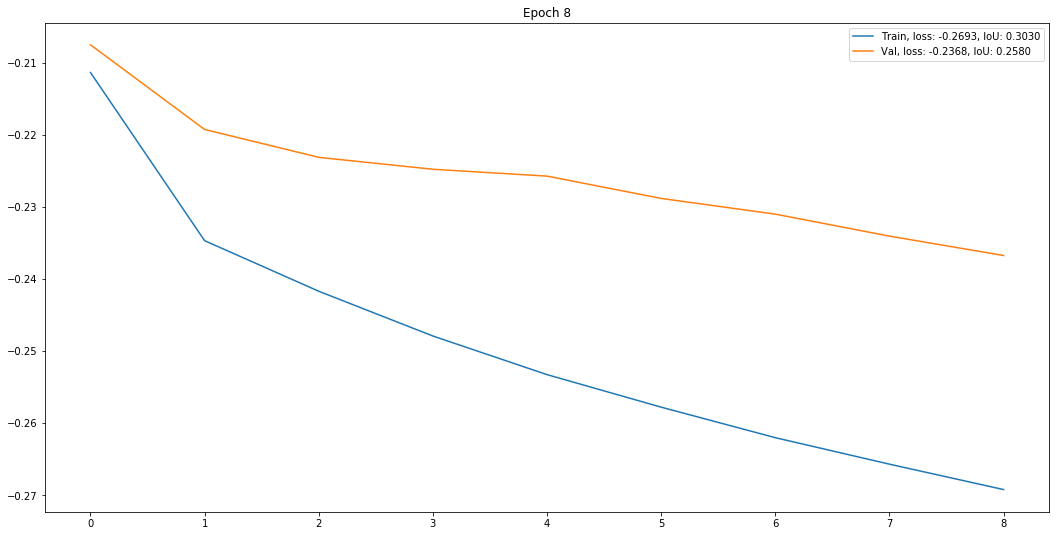

 Epoch: 9 of 50, Iter.: 44 of 44, Loss: -0.272428, Val. Loss: -0.239503
 Epoch: 9 of 50, Iter.: 44 of 44, IoU: 0.304289, Val. IoU: 0.258576


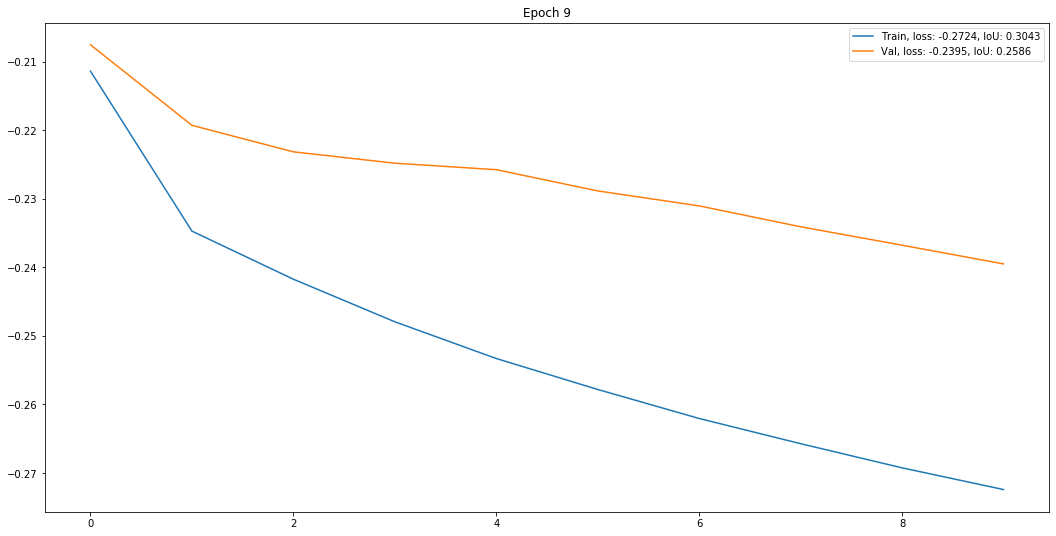

 Epoch: 10 of 50, Iter.: 44 of 44, Loss: -0.275327, Val. Loss: -0.241173
 Epoch: 10 of 50, Iter.: 44 of 44, IoU: 0.305495, Val. IoU: 0.258262


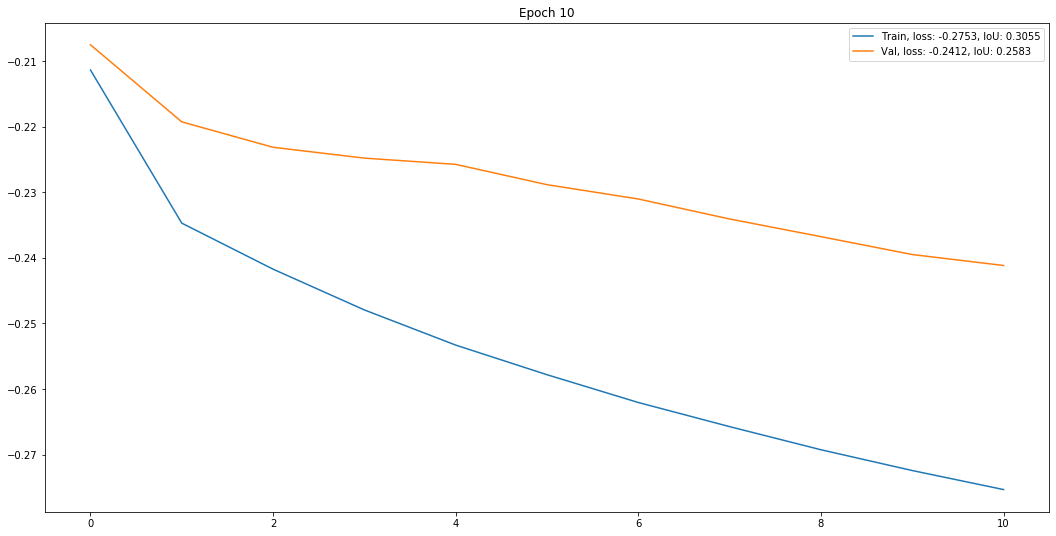

 Epoch: 11 of 50, Iter.: 44 of 44, Loss: -0.278056, Val. Loss: -0.244540
 Epoch: 11 of 50, Iter.: 44 of 44, IoU: 0.306397, Val. IoU: 0.260740


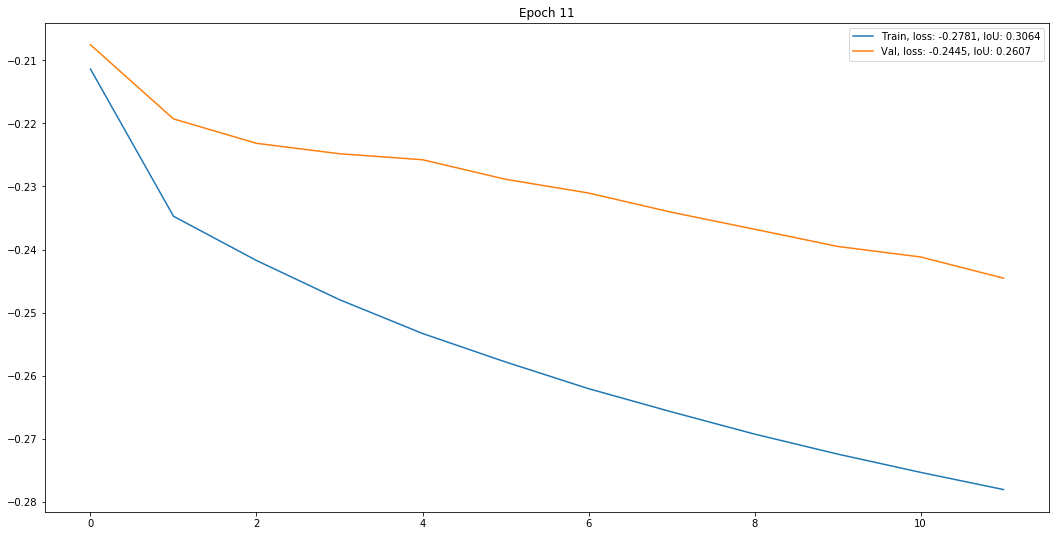

 Epoch: 12 of 50, Iter.: 44 of 44, Loss: -0.280705, Val. Loss: -0.245835
 Epoch: 12 of 50, Iter.: 44 of 44, IoU: 0.307749, Val. IoU: 0.259857


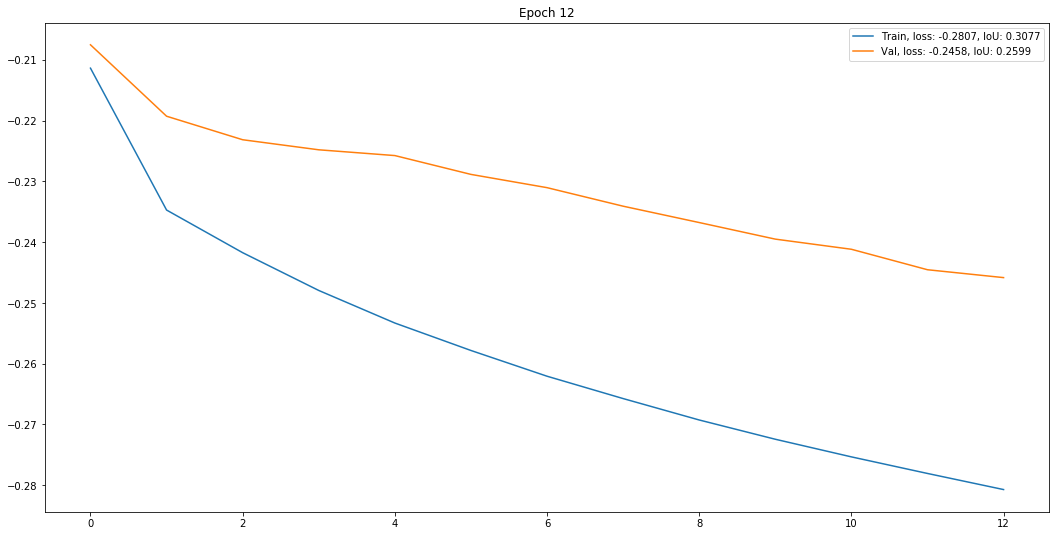

 Epoch: 13 of 50, Iter.: 44 of 44, Loss: -0.282915, Val. Loss: -0.247114
 Epoch: 13 of 50, Iter.: 44 of 44, IoU: 0.308413, Val. IoU: 0.260616


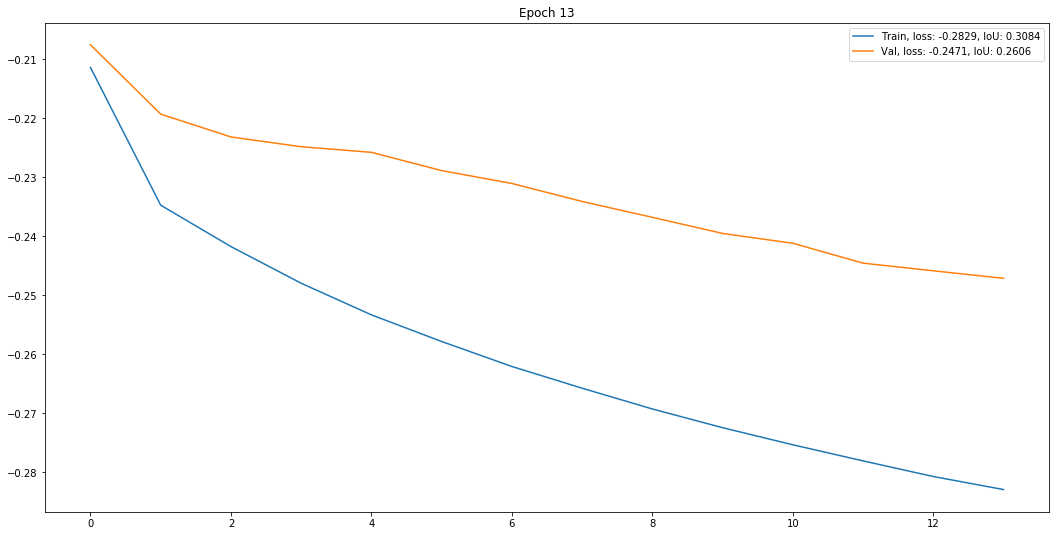

 Epoch: 14 of 50, Iter.: 44 of 44, Loss: -0.285283, Val. Loss: -0.248447
 Epoch: 14 of 50, Iter.: 44 of 44, IoU: 0.309525, Val. IoU: 0.260189


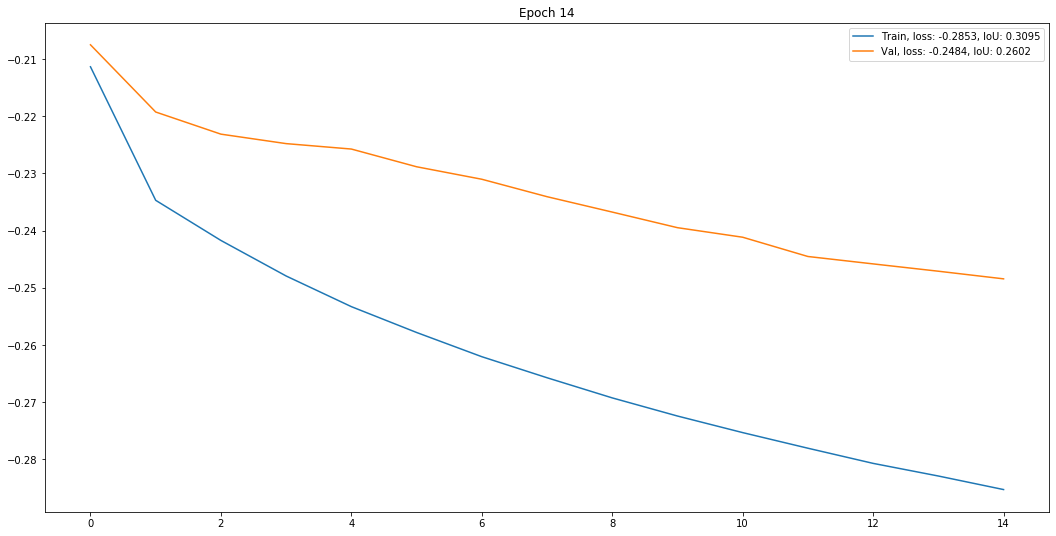

 Epoch: 15 of 50, Iter.: 42 of 44, IoU:  0.3082236

KeyboardInterrupt: 

In [49]:
train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_val_loss))
    print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_iou, epoch_val_iou))
    
    
    # plot 
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}')
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Val, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    if best_epoch == epoch:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'iou': best_iou,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [ ]:
best_epoch, best_iou

In [ ]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()

## Evaluate validation performance (full sized images)

In [ ]:
%ls ../checkpoints

In [ ]:
model_name = 'UNet_BCEWithLogitsLoss_attention'
# model_name = 'UNet_IoULoss_attention'
# model_name = 'UNet_IoUBCELoss_attention'


# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])
#model.eval()

# print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
# print(f'Validation iou ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'])

torchsummary.summary(model, (3, 256, 256), device='cuda') # Runs a basic test of the network. Very useful and clear!

In [ ]:
img.shape, img.dtype

In [ ]:
path_images = "../datasets/train-val/images"
path_masks = "../datasets/train-val/masks"

with open('../2020-MediaEval-Medico-polyp-segmentation-master/kvasir-seg-train-val/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]
    
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

## Produce predictions Validation Set

In [ ]:
%mkdir ../predictions_val

In [ ]:
PRED_PATH = '../predictions_val'
time_taken = []
ious = []


for name in ids_val:
    path_img = os.path.join(path_images, name)
    path_mask = os.path.join(path_masks, name)
    
    img = imageio.imread(path_img) / 255
    mask = imageio.imread(path_mask)[:, :, 0] / 255
    mask = mask.round() # binarize to 0 or 1 
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    mask_binary = torch.FloatTensor(mask).unsqueeze(0)
    
    # resize for the model
    img, mask = resize(img), resize(mask_binary)
    
    # put on the GPU
    img, mask = img.to(DEVICE), mask.to(DEVICE)
        
    # Start time
    start_time = time.time()
    ## Prediction
    pred = model(img)
    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
    # remove channel => BATCH x H x W
    pred = pred.squeeze(0)
    
    
    # sigmoid, threshold, record score
    ious.append(iou_pytorch_test(pred, mask_binary).item())    
    
    
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nMean FPS: ", mean_fps)

mean_iou = np.mean(ious)
print("Mean IoU: ", mean_iou)

In [ ]:
total_imgs = 10
for i, name in enumerate(ids_val):
    
    if i == total_imgs:
        break

    img = imageio.imread(f'../datasets/train-val/images/{name}')
    plt.imshow(img)
    plt.show()
    
    mask = imageio.imread(f'../datasets/train-val/masks/{name}')
    plt.imshow(mask)
    plt.show()
    
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.show()
    
    print(80 * '-')

## Produce predictions Test Set

In [ ]:
%mkdir ../predictions_test

In [ ]:
TEST_IMG_PATH = '../datasets/test/images'
os.listdir(TEST_IMG_PATH)[:20]

In [ ]:
TEST_PRED_PATH = '../predictions_test'
TEST_IMG_PATH = '../datasets/test/images'

time_taken = []
ious = []


for name in os.listdir(TEST_IMG_PATH):
    path_img = os.path.join(TEST_IMG_PATH, name)  
    img = imageio.imread(path_img) / 255
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    
    # resize for the model
    img = resize(img)
    
    # put on the GPU
    img = img.to(DEVICE)
        
    # Start time
    start_time = time.time()
    ## Prediction
    pred = model(img)
    # End timer
    end_time = time.time() - start_time

    time_taken.append(end_time)
    print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
        
    # remove channel: BATCH x 1 x H x W => BATCH x H x W
    pred = pred.squeeze(1)
        
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(TEST_PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nMean FPS: ", mean_fps)